In [1]:
import pandas as pd
import os
import numpy as np
import re
import torch
import torch.nn as nn
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.optim import AdamW
from torch.nn.functional import cross_entropy
from sklearn.model_selection import KFold
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertConfig, BertModel
from torch.optim import lr_scheduler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

/Users/nilanshadargan/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/nilanshadargan/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
data_companies = 'Data/data_companies.csv'
companies = pd.read_csv(data_companies, na_values=[''], keep_default_na=False)
companies['Data Uniqueness'].fillna('N/A', inplace=True)
companies = companies.dropna(subset=['UVP'])
companies.reset_index(drop=True, inplace=True)

companies

,company_id,company_name,short_description,long_description,batch,status,tags,location,country,year_founded,num_founders,founders_names,team_size,website,cb_url,linkedin_url,Scraped_Info,UVP,Data Uniqueness
0,28367,Atri Labs,Open-source web framework for Python developers,Atri Labs is Vercel for Python developers. \n\...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2022,2,"['Darshita Chaturvedi', 'Shyam Swaroop']",2,https://atrilabs.com,NaN,https://www.linkedin.com/company/atri-labs/,AI Insurance by Atri Insurance Solutions Polic...,Ok for 3-5 years,N/A
1,28183,Metal,Machine learning embeddings as a service,Metal does machine learning embeddings as a se...,W23,Active,"['Artificial Intelligence', 'Machine Learning'...",New York,US,2023,3,"['Taylor Lowe', ""James O'Dwyer"", 'Sergio Prada']",3,https://getmetal.io/,NaN,https://www.linkedin.com/company/getmetal/about/,AI for Financial Analysts | Metal metal. Secur...,Ok for 5-8 years,Large/Difficult to Obtain
2,28089,Thread,Incident Management platform for large enterpr...,Thread is an incident management tool for larg...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2023,3,"['Yuheng Wang', 'Harsha Vankayalapati', 'Akeem...",3,http://www.usethread.io,https://www.crunchbase.com/organization/thread...,https://www.linkedin.com/company/thread-incorp...,Customer Success Launch Home Contact The Lifel...,Ok for 1-2 years,Not Special/Publicly Available
3,27989,MagnaPlay,AI-powered game translation.,MagnaPlay is game translation simplified into ...,W23,Active,"['Artificial Intelligence', 'SaaS', 'Gaming']",San Francisco,US,2023,2,"['Pedro Esteves', 'Paulo Rodrigues']",3,https://magnaplay.com,NaN,https://www.linkedin.com/company/magnaplay/,MagnaPlay Localizing games should be child's p...,Ok for 1-2 years,Not Special/Publicly Available
4,27966,UpTrain AI,Open source Datadog for Machine Learning,UpTrain is an open-source tool to improve AI m...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2022,2,"['Sourabh Agrawal', 'Shikha Mohanty']",4,https://uptrain.ai/,NaN,https://www.linkedin.com/company/uptrain-ai,UpTrain | Full-Stack LLMOps Platform 📝 Read ou...,Ok for 5-8 years,Large/Difficult to Obtain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,13224,Ello,Building the world's first 1:1 AI teacher.,NaN,W20,Active,"['Artificial Intelligence', 'Education']",San Francisco,US,2020,3,"['Elizabeth Adams', 'Tom Sayer', 'Catalin Voss']",26,https://www.ello.com,NaN,NaN,Read With Ello How It Works Why Ello Parent Re...,Ok for 3-5 years,Large/Difficult to Obtain
107,13218,Turing Labs Inc.,AI for R&D of consumer brands like P&G to deve...,Developing a consumer product like Dove is com...,W20,Active,"['Artificial Intelligence', 'B2B']",New York,US,2019,2,"['Ajith Govind', 'Manmit Shrimali']",18,http://www.turingsaas.com,NaN,NaN,Turing Labs AI Home Platform Overview Resource...,Ok for 3-5 years,Large/Difficult to Obtain
108,13147,Replicate,Run machine learning models in the cloud,NaN,W20,Active,"['Artificial Intelligence', 'Developer Tools',...","Berkeley, CA",US,2019,2,"['Ben Firshman', 'Andreas Jansson']",11,https://replicate.com,https://www.crunchbase.com/organization/replicate,https://www.linkedin.com/company/replicate/,Replicate Menu Explore Pricing Docs Blog Chang...,Ok for 1-2 years,Not Special/Publicly Available
109,13144,Datasaur,Datasaur builds a data labeling workforce mana...,"Datasaur builds intelligent, optimized, human-...",W20,Active,"['Artificial Intelligence', 'Deep Learning', '...","Livermore, CA",US,2019,1,['Ivan Lee'],50,https://datasaur.ai,https://www.crunchbase.com/organization/datasaur,https://www.linkedin.com/company/datasaur/,The Best Text and Audio Data Labeling Platform...,Ok for 1-2 years,Large/Difficult to Obtain


In [3]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Combine text columns into one and fill NA with empty string, then concatenate
companies['text'] = companies[['short_description', 'long_description', 'Scraped_Info']].fillna('').agg(' '.join, axis=1)

# Text cleaning function
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

# Apply text cleaning
companies['text'] = companies['text'].apply(clean_text)

# Tokenizing text and creating attention masks in a batched manner
def tokenize_text(texts, max_length=512):
    encoded_batch = tokenizer.batch_encode_plus(texts, 
                                                add_special_tokens=True, 
                                                max_length=max_length, 
                                                padding='max_length', 
                                                truncation=True, 
                                                return_attention_mask=True)
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

# Tokenize the cleaned texts
input_ids, attention_masks = tokenize_text(companies['text'].tolist())
companies['input_ids'] = input_ids
companies['attention_masks'] = attention_masks

companies.head()

,company_id,company_name,short_description,long_description,batch,status,tags,location,country,year_founded,...,team_size,website,cb_url,linkedin_url,Scraped_Info,UVP,Data Uniqueness,text,input_ids,attention_masks
0,28367,Atri Labs,Open-source web framework for Python developers,Atri Labs is Vercel for Python developers. \n\...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2022,...,2,https://atrilabs.com,NaN,https://www.linkedin.com/company/atri-labs/,AI Insurance by Atri Insurance Solutions Polic...,Ok for 3-5 years,N/A,Open-source web framework for Python developer...,"[101, 2330, 1011, 3120, 4773, 7705, 2005, 1875...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,28183,Metal,Machine learning embeddings as a service,Metal does machine learning embeddings as a se...,W23,Active,"['Artificial Intelligence', 'Machine Learning'...",New York,US,2023,...,3,https://getmetal.io/,NaN,https://www.linkedin.com/company/getmetal/about/,AI for Financial Analysts | Metal metal. Secur...,Ok for 5-8 years,Large/Difficult to Obtain,Machine learning embeddings as a service Metal...,"[101, 3698, 4083, 7861, 8270, 4667, 2015, 2004...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,28089,Thread,Incident Management platform for large enterpr...,Thread is an incident management tool for larg...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2023,...,3,http://www.usethread.io,https://www.crunchbase.com/organization/thread...,https://www.linkedin.com/company/thread-incorp...,Customer Success Launch Home Contact The Lifel...,Ok for 1-2 years,Not Special/Publicly Available,Incident Management platform for large enterpr...,"[101, 5043, 2968, 4132, 2005, 2312, 9926, 1168...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,27989,MagnaPlay,AI-powered game translation.,MagnaPlay is game translation simplified into ...,W23,Active,"['Artificial Intelligence', 'SaaS', 'Gaming']",San Francisco,US,2023,...,3,https://magnaplay.com,NaN,https://www.linkedin.com/company/magnaplay/,MagnaPlay Localizing games should be child's p...,Ok for 1-2 years,Not Special/Publicly Available,AI-powered game translation. MagnaPlay is game...,"[101, 9932, 1011, 6113, 2208, 5449, 1012, 2020...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,27966,UpTrain AI,Open source Datadog for Machine Learning,UpTrain is an open-source tool to improve AI m...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2022,...,4,https://uptrain.ai/,NaN,https://www.linkedin.com/company/uptrain-ai,UpTrain | Full-Stack LLMOps Platform 📝 Read ou...,Ok for 5-8 years,Large/Difficult to Obtain,Open source Datadog for Machine Learning UpTra...,"[101, 2330, 3120, 2951, 16168, 2005, 3698, 408...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [4]:
# Define label mappings
uvp_labels = {
    'Already obsolete': 0,
    'Ok for 1-2 years': 1,
    'Ok for 3-5 years': 2,
    'Ok for 5-8 years': 3
}

db_labels = {
    'Large/Difficult to Obtain': 0,
    'Quantity questionable': 1,
    'Not Special/Publicly Available': 2,
    'N/A': 3
}

# Encode the labels
companies['uvp_label'] = companies['UVP'].map(uvp_labels)
companies['db_label'] = companies['Data Uniqueness'].map(db_labels)
# Check unique values and types for labels in the DataFrame
print("Unique UVP Labels:", companies['uvp_label'].unique())
print("Unique DB Labels:", companies['db_label'].unique())
print("Data Types:", companies['uvp_label'].dtype, companies['db_label'].dtype)



# Display the first few rows of the dataframe with the new labels
companies.head()

Unique UVP Labels: [2 3 1 0]
Unique DB Labels: [3 0 2 1]
Data Types: int64 int64


,company_id,company_name,short_description,long_description,batch,status,tags,location,country,year_founded,...,cb_url,linkedin_url,Scraped_Info,UVP,Data Uniqueness,text,input_ids,attention_masks,uvp_label,db_label
0,28367,Atri Labs,Open-source web framework for Python developers,Atri Labs is Vercel for Python developers. \n\...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2022,...,NaN,https://www.linkedin.com/company/atri-labs/,AI Insurance by Atri Insurance Solutions Polic...,Ok for 3-5 years,N/A,Open-source web framework for Python developer...,"[101, 2330, 1011, 3120, 4773, 7705, 2005, 1875...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,3
1,28183,Metal,Machine learning embeddings as a service,Metal does machine learning embeddings as a se...,W23,Active,"['Artificial Intelligence', 'Machine Learning'...",New York,US,2023,...,NaN,https://www.linkedin.com/company/getmetal/about/,AI for Financial Analysts | Metal metal. Secur...,Ok for 5-8 years,Large/Difficult to Obtain,Machine learning embeddings as a service Metal...,"[101, 3698, 4083, 7861, 8270, 4667, 2015, 2004...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,0
2,28089,Thread,Incident Management platform for large enterpr...,Thread is an incident management tool for larg...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2023,...,https://www.crunchbase.com/organization/thread...,https://www.linkedin.com/company/thread-incorp...,Customer Success Launch Home Contact The Lifel...,Ok for 1-2 years,Not Special/Publicly Available,Incident Management platform for large enterpr...,"[101, 5043, 2968, 4132, 2005, 2312, 9926, 1168...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,2
3,27989,MagnaPlay,AI-powered game translation.,MagnaPlay is game translation simplified into ...,W23,Active,"['Artificial Intelligence', 'SaaS', 'Gaming']",San Francisco,US,2023,...,NaN,https://www.linkedin.com/company/magnaplay/,MagnaPlay Localizing games should be child's p...,Ok for 1-2 years,Not Special/Publicly Available,AI-powered game translation. MagnaPlay is game...,"[101, 9932, 1011, 6113, 2208, 5449, 1012, 2020...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,2
4,27966,UpTrain AI,Open source Datadog for Machine Learning,UpTrain is an open-source tool to improve AI m...,W23,Active,"['Artificial Intelligence', 'Developer Tools',...",San Francisco,US,2022,...,NaN,https://www.linkedin.com/company/uptrain-ai,UpTrain | Full-Stack LLMOps Platform 📝 Read ou...,Ok for 5-8 years,Large/Difficult to Obtain,Open source Datadog for Machine Learning UpTra...,"[101, 2330, 3120, 2951, 16168, 2005, 3698, 408...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,0


In [5]:
def calculate_majority_class_accuracy(labels):
    label_count = Counter(labels)
    most_common_label_count = label_count.most_common(1)[0][1]
    majority_class_accuracy = most_common_label_count / len(labels)
    return majority_class_accuracy

def calculate_random_predictor_accuracy(labels):
    label_count = Counter(labels)
    total_count = sum(label_count.values())
    random_accuracy = sum((count / total_count) ** 2 for count in label_count.values())
    return random_accuracy



majority_accuracy_uvp = calculate_majority_class_accuracy(companies['uvp_label'])
majority_accuracy_db = calculate_majority_class_accuracy(companies['db_label'])

random_accuracy_uvp = calculate_random_predictor_accuracy(companies['uvp_label'])
random_accuracy_db = calculate_random_predictor_accuracy(companies['db_label'])


print(f"Majority Class Predictor Accuracy for UVP: {majority_accuracy_uvp:.2f}")
print(f"Majority Class Predictor Accuracy for Data Uniqueness: {majority_accuracy_db:.2f}")



print(f"Random Predictor Accuracy for UVP: {random_accuracy_uvp:.2f}")
print(f"Random Predictor Accuracy for Data Uniqueness: {random_accuracy_db:.2f}")



Majority Class Predictor Accuracy for UVP: 0.45
Majority Class Predictor Accuracy for Data Uniqueness: 0.50
Random Predictor Accuracy for UVP: 0.31
Random Predictor Accuracy for Data Uniqueness: 0.37


In [6]:
# Custom Dataset class
class CompanyDataset(Dataset):
    def __init__(self, input_ids, attention_masks, uvp_labels, db_labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.uvp_labels = uvp_labels
        self.db_labels = db_labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'uvp_label': torch.tensor(self.uvp_labels[idx], dtype=torch.long),
            'db_label': torch.tensor(self.db_labels[idx], dtype=torch.long)
        }

In [7]:
class MultiLabelBERT(torch.nn.Module):
    def __init__(self, bert_model_name, num_labels1, num_labels2):
        super(MultiLabelBERT, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = torch.nn.Dropout(0.4)
        self.classifier1 = torch.nn.Linear(self.bert.config.hidden_size, num_labels1)
        self.classifier2 = torch.nn.Linear(self.bert.config.hidden_size, num_labels2)

        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  

        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        return logits1, logits2

In [9]:
def cross_validate_model(companies, num_splits=5):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    all_uvp_preds, all_uvp_labels = [], []
    all_db_preds, all_db_labels = [], []

    for fold, (train_index, val_index) in enumerate(kf.split(companies['input_ids']), 1):
        print(f"Fold {fold}")
        train_dataset = CompanyDataset(
            [companies['input_ids'][i] for i in train_index],
            [companies['attention_masks'][i] for i in train_index],
            [companies['uvp_label'][i] for i in train_index],
            [companies['db_label'][i] for i in train_index]
        )
        val_dataset = CompanyDataset(
            [companies['input_ids'][i] for i in val_index],
            [companies['attention_masks'][i] for i in val_index],
            [companies['uvp_label'][i] for i in val_index],
            [companies['db_label'][i] for i in val_index]
        )

        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=8)

        model = MultiLabelBERT('bert-base-uncased', num_labels1=len(set(companies['uvp_label'])), num_labels2=len(set(companies['db_label'])))
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)  

        class_weights_uvp = compute_class_weight('balanced', classes=np.unique(companies['uvp_label']), y=companies['uvp_label'])
        class_weights_db = compute_class_weight('balanced', classes=np.unique(companies['db_label']), y=companies['db_label'])
        class_weights_uvp = torch.tensor(class_weights_uvp, dtype=torch.float).to(device)
        class_weights_db = torch.tensor(class_weights_db, dtype=torch.float).to(device)

        # Training phase
        for epoch in range(5): 
            model.train()
            total_loss, total_correct, total_samples = 0, 0, 0
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                uvp_labels = batch['uvp_label'].to(device)
                db_labels = batch['db_label'].to(device)

                uvp_logits, db_logits = model(input_ids, attention_mask)
                loss1 = F.cross_entropy(uvp_logits, uvp_labels, weight=class_weights_uvp)
                loss2 = F.cross_entropy(db_logits, db_labels, weight=class_weights_db)
                loss = loss1 + loss2
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_correct += (uvp_logits.argmax(1) == uvp_labels).sum().item() + (db_logits.argmax(1) == db_labels).sum().item()
                total_samples += uvp_labels.size(0) + db_labels.size(0)

            train_accuracy = total_correct / total_samples
            print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}, Accuracy: {train_accuracy:.4f}')

        # Validation phase
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                uvp_labels = batch['uvp_label'].to(device)
                db_labels = batch['db_label'].to(device)

                uvp_logits, db_logits = model(input_ids, attention_mask)
                uvp_preds = uvp_logits.argmax(1)
                db_preds = db_logits.argmax(1)

                all_uvp_preds.extend(uvp_preds.cpu().numpy())
                all_uvp_labels.extend(uvp_labels.cpu().numpy())
                all_db_preds.extend(db_preds.cpu().numpy())
                all_db_labels.extend(db_labels.cpu().numpy())

    results = {
        'uvp_preds': all_uvp_preds,
        'uvp_labels': all_uvp_labels,
        'db_preds': all_db_preds,
        'db_labels': all_db_labels
    }
    
    return results

In [ ]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [10]:
def plot_confusion_matrices(results):
    uvp_cm = confusion_matrix(results['uvp_labels'], results['uvp_preds'])
    db_cm = confusion_matrix(results['db_labels'], results['db_preds'])

    plot_confusion_matrices(uvp_cm, ['Already obsolete', 'Ok for 1-2 years', 'Ok for 3-5 years', 'Ok for 5-8 years'], "UVP Confusion Matrix")
    plot_confusion_matrices(db_cm, ['Large/Difficult to Obtain', 'Quantity questionable', 'Not Special/Publicly Available', 'N/A'], "DB Confusion Matrix")


In [11]:

results = cross_validate_model(companies)


Fold 1
Epoch 1, Loss: 2.8940913026983086, Accuracy: 0.2557
Epoch 2, Loss: 2.8012396422299473, Accuracy: 0.3239
Epoch 3, Loss: 2.890068292617798, Accuracy: 0.3693
Epoch 4, Loss: 2.84454590624029, Accuracy: 0.3125
Epoch 5, Loss: 2.950217138637196, Accuracy: 0.2841
Fold 2
Epoch 1, Loss: 2.893981178601583, Accuracy: 0.2135
Epoch 2, Loss: 2.734688679377238, Accuracy: 0.2978
Epoch 3, Loss: 2.8144962986310325, Accuracy: 0.3146
Epoch 4, Loss: 2.7612854639689126, Accuracy: 0.3652
Epoch 5, Loss: 2.7645695010821023, Accuracy: 0.3483
Fold 3
Epoch 1, Loss: 2.86290309826533, Accuracy: 0.2303
Epoch 2, Loss: 2.705993374188741, Accuracy: 0.3596
Epoch 3, Loss: 2.6561784148216248, Accuracy: 0.3876
Epoch 4, Loss: 2.5777544180552163, Accuracy: 0.4270
Epoch 5, Loss: 2.539800306161245, Accuracy: 0.3989
Fold 4
Epoch 1, Loss: 3.034204045931498, Accuracy: 0.2022
Epoch 2, Loss: 2.8288331031799316, Accuracy: 0.2079
Epoch 3, Loss: 2.7322800556818643, Accuracy: 0.3764
Epoch 4, Loss: 2.7001208464304605, Accuracy: 0.

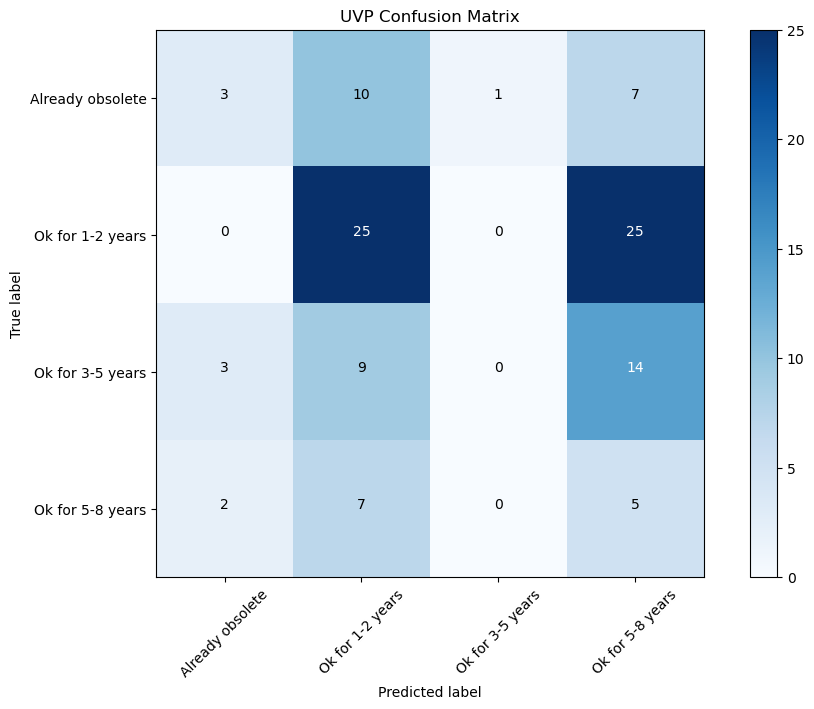

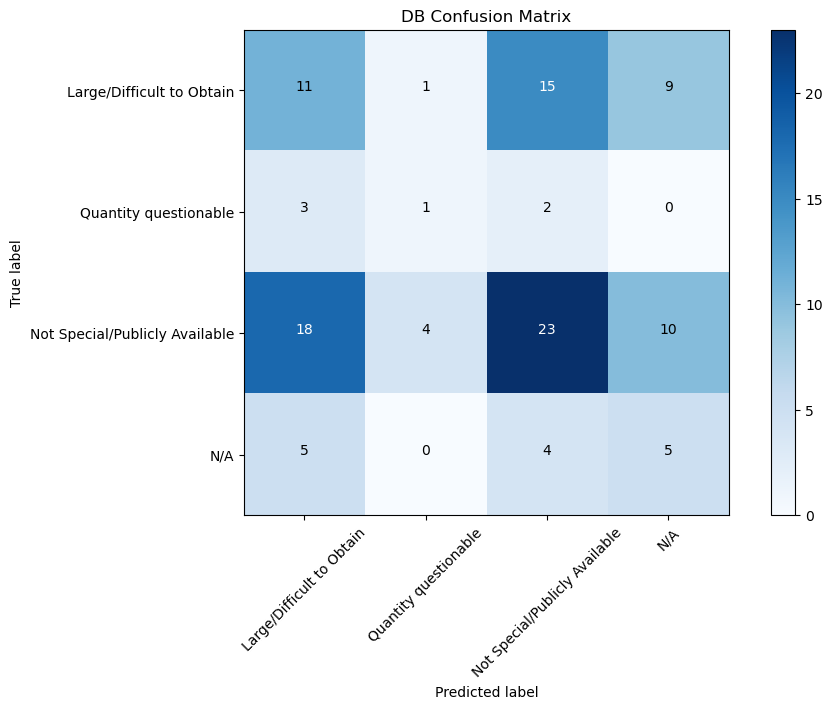

In [14]:
plot_confusion_matrices(results)